<a href="https://colab.research.google.com/github/azzy-chemE/Rayfield-Systems-HUVTSP/blob/main/Rayfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Pushkar-Kamma/Rayfield-Systems-HUVTSP.git
%cd Rayfield-Systems-HUVTSP


Cloning into 'Rayfield-Systems-HUVTSP'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 38 (delta 16), reused 18 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 906.53 KiB | 14.39 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/Rayfield-Systems-HUVTSP/Rayfield-Systems-HUVTSP/Rayfield-Systems-HUVTSP


In [ ]:
!ls


cleaned_data.csv  logo.png   predictions.csv  script.js
index.html	  model.pkl  README.md	      style.css


In [ ]:
!pwd



/content/Rayfield-Systems-HUVTSP/Rayfield-Systems-HUVTSP/Rayfield-Systems-HUVTSP


# Day 1: Define Use Case + Baseline Model

## Task 1.1: Define Your ML Problem

**Workflow pain point:**  
We want to forecast the **Active Power (kW)** generated by wind turbines using available sensor data. This helps predict energy output and detect potential maintenance needs.

**Input data:**  
- Wind speed (m/s)  
- Theoretical power (kWh)  
- Wind direction (degrees)  
- Datetime (used as index for time-series order)

**Expected output:**  
- Predicted Active Power (kW) for given conditions.



In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load dataset from repo
df = pd.read_csv('cleaned_data.csv')

# Convert Datetime column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Features: wind speed, theoretical power, wind direction
X = df[['WindSpeed_mps', 'TheoreticalPower_kWh', 'WindDirection_deg']]
y = df['ActivePower_kW']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Linear Regression model
model = LinearRegression().fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print("Baseline MSE:", mean_squared_error(y_test, preds))


Baseline MSE: 66388.30222675888


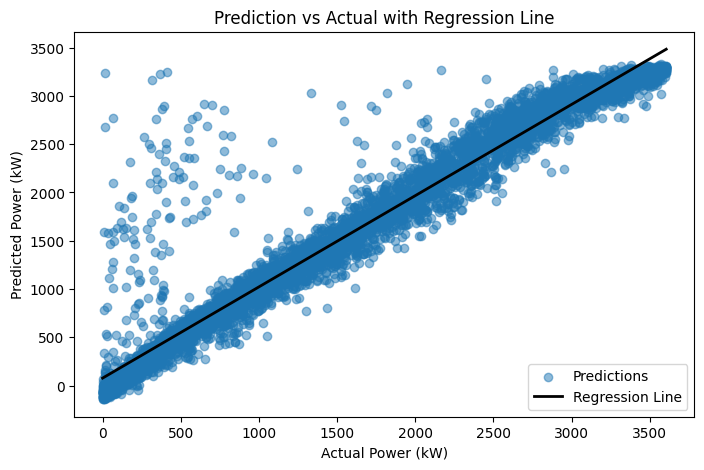

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot of predictions vs actual values
plt.figure(figsize=(8,5))
plt.scatter(y_test, preds, alpha=0.5, label="Predictions")

# Calculate regression line (best fit line)
m, b = np.polyfit(y_test, preds, 1)  # slope and intercept
x_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(x_line, m*x_line + b, color='black', linewidth=2, label="Regression Line")

# Labels and title
plt.xlabel("Actual Power (kW)")
plt.ylabel("Predicted Power (kW)")
plt.title("Prediction vs Actual with Regression Line")
plt.legend()
plt.show()


In [ ]:
# Info and descriptive stats
print(df.info())
print(df.describe())

# Create rolling average feature (7 intervals)
df['rolling_7'] = df['ActivePower_kW'].rolling(7).mean().fillna(0)

# Update features to include rolling average
X = df[['WindSpeed_mps', 'TheoreticalPower_kWh', 'WindDirection_deg', 'rolling_7']]

# Re-split with new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33908 entries, 0 to 33907
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Datetime              33908 non-null  datetime64[ns]
 1   ActivePower_kW        33908 non-null  float64       
 2   WindSpeed_mps         33908 non-null  float64       
 3   TheoreticalPower_kWh  33908 non-null  float64       
 4   WindDirection_deg     33908 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.3 MB
None
                            Datetime  ActivePower_kW  WindSpeed_mps  \
count                          33908    33908.000000   33908.000000   
mean   2018-07-10 05:07:52.047894272     1393.688292       7.750832   
min              2018-01-01 00:00:00        0.028733       3.002270   
25%              2018-04-23 21:57:30      418.380630       5.681448   
50%              2018-07-12 14:35:00     1114.658996       7.539577

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Parameter grid for Decision Tree
params = {"max_depth": [2, 5, 10]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params, cv=3)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_


Best params: {'max_depth': 10}


Feature Importances: [0.01810811 0.94529646 0.00446549 0.03212994]


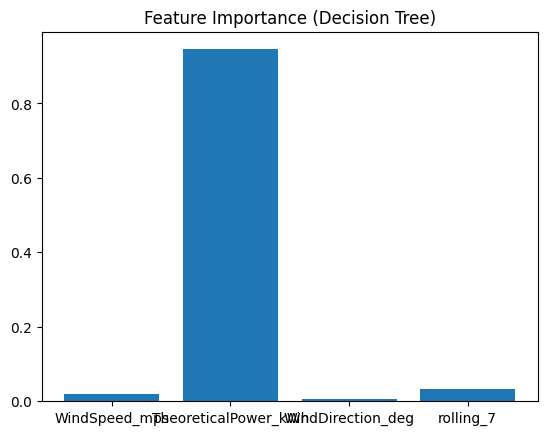

In [ ]:
# Feature importance (for Decision Tree)
importance = best_model.feature_importances_
print("Feature Importances:", importance)

# Plot feature importance
plt.bar(X.columns, importance)
plt.title("Feature Importance (Decision Tree)")
plt.show()


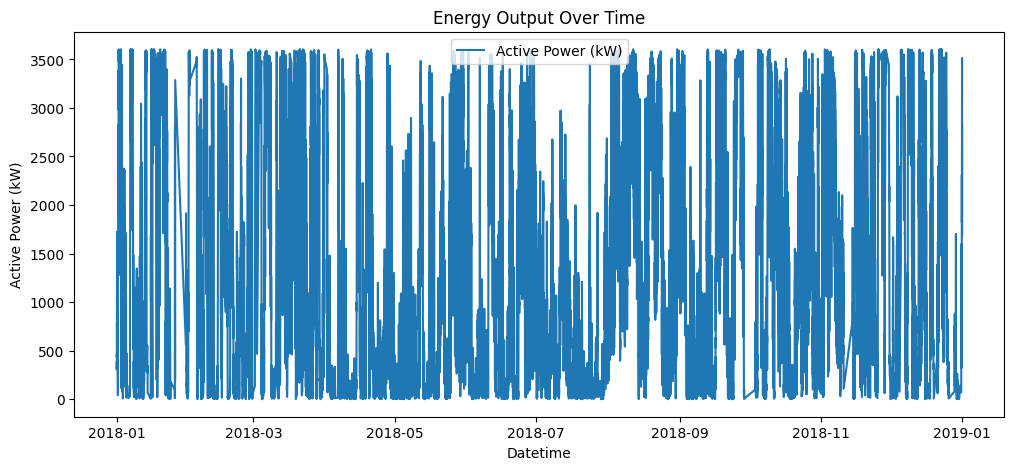

In [ ]:
# Plot energy output over time
plt.figure(figsize=(12,5))
plt.plot(df['Datetime'], df['ActivePower_kW'], label='Active Power (kW)')
plt.title("Energy Output Over Time")
plt.xlabel("Datetime")
plt.ylabel("Active Power (kW)")
plt.legend()
plt.show()


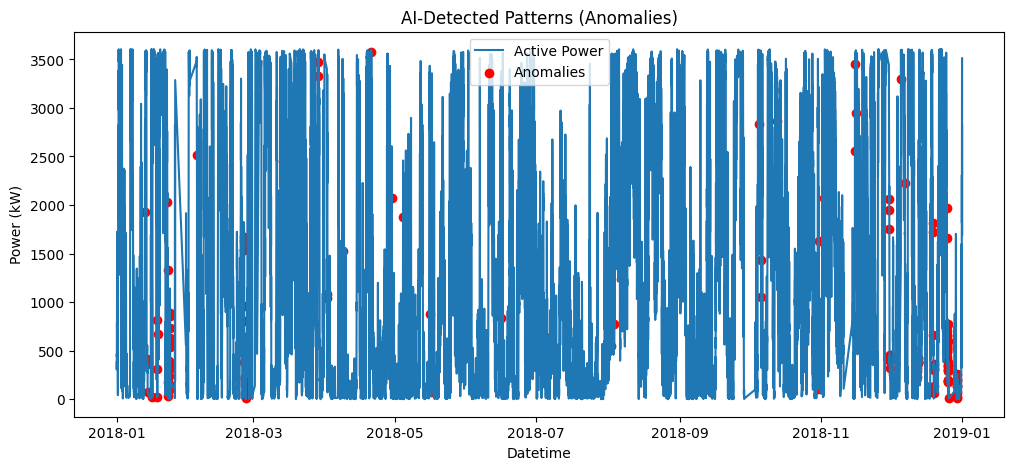

In [ ]:
# Simple anomaly threshold (difference > 500 kW)
errors = abs(y_test - preds)
anomalies = errors > 500

plt.figure(figsize=(12,5))
plt.plot(df['Datetime'], df['ActivePower_kW'], label='Active Power')
plt.scatter(df['Datetime'].iloc[y_test.index[anomalies]],
            y_test[anomalies],
            color='red', label='Anomalies')
plt.title("AI-Detected Patterns (Anomalies)")
plt.xlabel("Datetime")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
import pickle

def train_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def predict(model, X):
    return model.predict(X)


In [ ]:
# Train model using function
model_func = train_model(X_train, y_train)

# Predict
preds_func = predict(model_func, X_test)

# Save predictions to CSV
predictions_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": preds_func
})
predictions_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

# Save trained model as pickle file
with open("model.pkl", "wb") as f:
    pickle.dump(model_func, f)
print("Model saved to model.pkl")


Predictions saved to predictions.csv
Model saved to model.pkl


In [ ]:
!git remote remove origin
!git remote add origin https://github.com/Pushkar-Kamma/Rayfield-Systems-HUVTSP.git

In [ ]:
!git config --global user.email "pushkarkamma@gmail.com"
!git config --global user.name "Pushkar Kamma"

In [ ]:
!git add predictions.csv model.pkl
!git commit -m "Add predictions and model outputs"
!git push origin main


On branch main
nothing to commit, working tree clean
